# MCB 112 PSet 05


## Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt     
import pandas as pd                 # optional
import seaborn as sns               # optional

%matplotlib inline

In [2]:
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

numpy     : 1.26.4
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.3
jupyterlab: 4.2.5

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



## 1. test Moriarty's method yourself

Below, I copy the `read_fasta` function from my solutions to PSet1. I will use this function to read in fasta files that only contain a single sequence. I also define a new function `read_fasta_multi` that reads in each sequence from a fasta file containing multiple sequences. Briefly, this function initializes two lists: 1) `seqs` is a 2d list that stores each sequence present in the file as a list, 2) `read` is a 1d list representing the sequence currently being read. Then I use, the built-in Python `open` function to read through the file line-by-line. If we encounter the character '>', it means that we are starting to read in a new sequence, so I append `read` to `seqs` (if `read` is not empty) and then reset `read` to an empty list in preparation to read in the next sequence in the file. After iterating through the entire file, I return `seqs`, which is now a list of read-in sequences.

In [3]:
def read_fasta (filename):
    seq = []
    
    with open(filename) as f:
        for line in f:
            if '>' in line:
                continue
            else:
                seq.extend([x for x in line if x.isalpha()])
    return seq

In [4]:
def read_fasta_multi(filename):
    seqs = [] #this will store our read-in sequences
    read = [] #this will store the sequence currently being read
    with open(filename) as f: #opens the file
        for line in f: #reads it line-by-line
            if '>' in line: #indicates we are moving onto a new sequence
                if len(read) != 0: #add read to seqs if read is not empty
                    seqs.append(read)
                    read = [] #reset read in preparation for the next sequence
            else:
                read.extend([x for x in line if x.isalpha()]) #adds the latest line of the file to read
        if (len(read) != 0):
            seqs.append(read) #adds the final read to seqs
    return seqs

Below, I implement the Moriarty Method for identifying strep-type phage. As described in the problem set, this method simply calculates a score for each sequence, where each G/C that appears adds one to the score, and each A/T that appears subtracts one. In the function `moriarty_method`, I implement this method, returning the Moriarty score for a given sequence. 

In [5]:
def moriarty_method(seq):
    score = 0 #initializes score
    for base in seq: #loops through each base in seq
        if base == 'A' or base == 'T': #subract 1 if base is A/T
            score -= 1
        else: #add 1 if base is G/C
            score += 1
    return score

Below, I compute the distribution of Moriarty Scores for each set of test sequences we are given: 1) known strep sequences, 2) known micro sequences, 3) negative control sequences generated from a uniform base distribution model. I start by reading the fasta files for each set and the initializing lists that will store the scores for each set. Then, I use a `for` loop to loop through each of the 10,000 sequence reads in the three databses and add their Moriarty scores to their respective arrays. I then plot the distributions of scores for each set as histograms. 

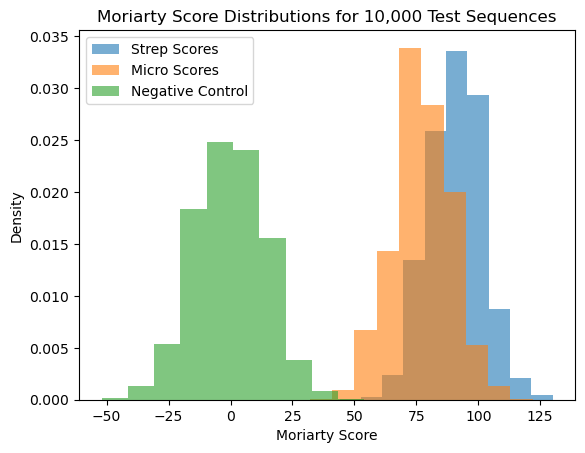

In [6]:
strep_tests = read_fasta_multi("strep-test.fa") #reads strep-test.fa 
micro_tests = read_fasta_multi("micro-test.fa") #reads micro-test.fa
neg_control = read_fasta_multi("moriarty-neg.fa") #reads negative control sequences

strep_scores = [] #will store scores for known strep sequences
micro_scores = [] #will store scores for known micro sequences
neg_scores = [] #will store scores for negative control sequences

for i in range(len(strep_tests)): #loops through each of the 10,000 sequences in the databases
    strep_scores.append(moriarty_method(strep_tests[i])) #compute the strep read Moriarty score
    micro_scores.append(moriarty_method(micro_tests[i])) #compute the micro read Moriarty score
    neg_scores.append(moriarty_method(neg_control[i])) #compute the negative control read Moriarty score

#Plotting histograms
plt.hist(strep_scores, label = "Strep Scores", alpha = 0.6, density = True)
plt.hist(micro_scores, label = "Micro Scores", alpha = 0.6, density = True)
plt.hist(neg_scores, label = "Negative Control", alpha = 0.6, density = True)
plt.xlabel("Moriarty Score")
plt.ylabel("Density")
plt.title("Moriarty Score Distributions for 10,000 Test Sequences")
plt.legend()
plt.show()

Next, I write code to produce a ROC plot for Moriarty's test. I will loop through 200 evenly spaced cutoff values from -60 to 130, a range chosen looking at the extreme values on the histogram above. For each cutoff value, I will calculate sensitivity and false positive rates and store them in their respective lists. From the distributions shown above, I will classify a read as strep if its Moriarty score is greater than the cutoff, and I will classify a read as micro if its Moriarty score is less than the cutoff. 

For each cutoff value, I create a length 10,000 1d numpy array of booleans called `strep_booleans` that represent whether the Moriarty scores for the 10,000 strep sequences are greater than or equal to the cutoff. I then convert these booleans to indicator variables, where 1 represents a positive classification as strep, and 0 represents an incorrect classification as micro. I calculate a similar array of indicators for the 10,000 Moriarty scores for the micro database. 

It's time to calculate our classification rates. I start by calculating the number of true positive classifications `true_pos` as the sum of the elements in `strep_indicators`, and the number of false positives `false_pos` is the sum of the elements in `micro_indicators` (since a 1 represents a classification as strep and a 0 represents a classification as micro). Then I calculate the number of true negatives by counting the number of entries in `micro_indicators` that are equal to 0 (properly identified as micro). Similarly, I calculate the number of false negatives by counting the number of entries in `strep_indicators` that are equal to 0. 

Finally, I append to the sensitivity list the quantity $TPR = \frac{TP}{TP + FN}$ and append to the false positive rate list the quantity $FPR = \frac{FP}{TN + FP}$. I then plot a graph of Sensitivity vs. False Positive Rate. 

In [7]:
#Calculations for ROC 
sensitivity = [] #stores sensitivity values for different cutoffs
fpr = [] #stores false positive rate for different cutoffs 

for cutoff in np.linspace(-60, 130, num = 200): #loops through different cutoff values
    strep_booleans = np.array(strep_scores) >= cutoff #true positive strep ID's marked as True, False otherwise
    strep_indicators = strep_booleans.astype(int) #true positive strep ID's marked as 1, 0 otherwise

    micro_booleans = np.array(micro_scores) >= cutoff #false positive strep ID's marked as True, False otherwise
    micro_indicators = micro_booleans.astype(int) #false positive strep ID's marked as 1, 0 otherwise
 
    true_pos = np.sum(strep_indicators) #number of true positive ID's
    false_pos = np.sum(micro_indicators) #number of false positive ID's

    true_neg = np.sum(micro_indicators == 0) #number of true negative ID's
    false_neg = np.sum(strep_indicators == 0) #number of false negative ID's

    sensitivity.append(true_pos/(true_pos + false_neg)) #computes + appends sensitivity value
    fpr.append(false_pos/(true_neg + false_pos)) #computes + appends false positive rate

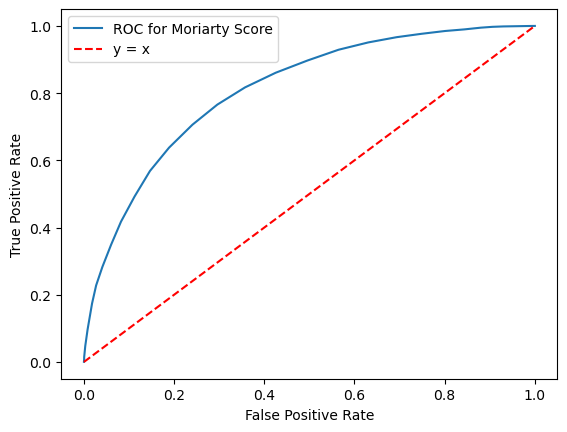

In [8]:
#Plotting ROC

plt.plot(fpr, sensitivity, label = "ROC for Moriarty Score")
x = np.linspace(0, 1, num = 200)
plt.plot(x,x, label = "y = x", c = 'r', linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In the above histogram, we confirm Moriarty's finding that his scoring method can distinguish between Strep phage sequences and negative control sequences generated from a uniform probability model (where each base is equally likely). We see, however, that the Moriarty score doesn't have the power to distinguish between sequence reads from Strep and Micro phage: large density from these distributions overlap on the histogram. 

The above ROC plot also displays a deviation from the ideal behavior shown in Moriarty's plot. The true positive rate increases more slowly as a function of false positive rate than in Moriarty's comparison of negative control and strep sequences. Interpreting this trend, we conlcude that in order to make Moriarty's test more sensitive to identifying strep from micro, we're also accepting a higher false positive rate (incorrectly identifying micro as strep). 

We expect this result because the Moriarty Score is effectively a proxy for the GC content of a sequence. Below, we define a function `gc_comp` that will compute the GC content of a given sequence and then loop through each sequence in the three databases to estimate the average GC content for Streph phage (0.73), Micro Phage (0.69), and negative control sequences (0.50, by construction). 

These results show that the Moriarty score can distinguish between Strep phage reads and negative control sequences because they have such vastly different GC contents. When the GC content gets more similar (as is the case between Strep and Micro phage reads), however, this score becomes less informative. 

In [9]:
def gc_comp(seq):
    gc = 0 #counter for number of G's and C's
    for base in seq:
        if base == "G" or base == "C":
            gc += 1 #increments if we encounter a G or C
    return gc/len(seq) #returns proportion of bases that are G or C

In [10]:
strep_gc = [] #stores gc content of 10,000 strep sequences
micro_gc = [] #stores gc content of 10,000 micro sequences
neg_gc = [] #stores gc content of 10,000 negative control sequences

for i in range(len(strep_tests)):
    strep_gc.append(gc_comp(strep_tests[i])) #computes gc content for i-th strep sequence
    micro_gc.append(gc_comp(micro_tests[i])) #computes gc content for i-th micro sequence
    neg_gc.append(gc_comp(neg_control[i])) #computes gc content for i-th negative control sequence

print("Average Strep GC Content = ", np.round(np.mean(strep_gc), decimals = 3), "\nAverage Micro GC Content = ", np.round(np.mean(micro_gc), decimals = 3), "\nAverage negative control GC Content = ", np.round(np.mean(neg_gc), decimals = 3))

Average Strep GC Content =  0.727 
Average Micro GC Content =  0.692 
Average negative control GC Content =  0.5


## 2. make your own method

In the code that follows, I will repeatedly refer to the set of 16 sequences of two-nucleotide pairs, where order matters. To encode these numerically for representation in lists and arrays, I define a `get_indices()` function that returns a list of these 16 nucleotide pairs in a consistent order. This list will serve as the "reference", from which I get the numeric indices of each nucleotide pair. 

In [11]:
def get_indices():
    bases = ['A', 'C', 'G', 'T'] #list of our four bases
    indices = [] #empty list to which we'll append our pairs
    for i in range(len(bases)): #nested for loop loops through each pair of bases
        for j in range(len(bases)):
            indices.append(''.join([bases[i], bases[j]])) #appends a pair to the indices array
    return indices

In [12]:
print(get_indices())

['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']


Next, I define a function `make_model` function that, when given a nucleotide sequence returns a $16 \times 4$ matrix containing all the information we'll need to calculate the parameters of a Markov Model based on the input sequence. 

The matrix $M$ can be thought of encoding the transition probabilities of seeing one of the four nucleotides (represented by the four columns) given the previous two nucleotides in the sequence (represented by the 16 rows). Unlike a traditional transition matrix for a Markov Model, however, the rows of $M$ are not normalized (not forced to sum to 1), which allows us to extract the model's marginal probabilities of each of the 16 nucleotide pairs from the matrix by summing the elements of its corresponding row in the matrix. This means, however, that when calculating transition probabilities, we'll need to normalize by these marginal probabilities. For example, the probability of the sequence 'AA' appearing in the model is $P(AA) = \sum_{i = 1}^n M_{1i}$. And the probability of a nucleotide being 'A', given the previous two nucleotides are 'AA' is: $P(x_i = A \mid x_{i-1} = A, x_{i-2} = A) = \frac{M_{11}}{\sum_{i = 1}^n M_{1i}}$. 

Briefly outlining the function below, I start by generating `index` my reference list for the 16 possible nucleotide pairs. I then initialize an array `duples` that will keep track of the frequencies with which each of these 16 sequences occurs in the training sequence. To populate this array, I use a `for` loop to loop through the test sequence, read each pair of nucleotides, and increment the corresponding entry in `duples`. After finishing the loop, I normalize these counts to probabilities. Then, I initialize the $16 \times 4$ matrix `matrix` that will encode all our parameters. I once again loop through the training sequence, this time reading in the previous two nucleotide pair ($x_{i-1}, x_{i-2}$) as well as the single nucleotide that comes after it ($x_i$). I then increment the entry in `matrix` that corresponds to observing this transition. After reading the test sequence in this manner, I divide each entry in `matrix` by the sum of all elements in `matrix` to convert from counts to marginal probabilities. 

In [13]:
def make_model(seq):

    index = get_indices() #gets the reference indices list for our 16 possible nucleotide pairs

    #Gets the marginal probabilities of each duple of bases: i.e., P(x_ix_{i+1})
    duples = np.zeros(len(index)) #this will store these probabilities
    
    for i in range(len(seq)-1): #loops through the training sequence
        current = seq[i:i+2] #reads the current pair of nucleotides
        duples[index.index(current)] += 1 #increments the corresponding index in duples
    duples = duples/np.sum(duples) #normalizes from counts to probabilities


    bases = ['A', 'C', 'G', 'T'] #reference list of bases for indexing
    
    matrix = np.zeros((len(index), 4)) #this will be our model matrix M
    for i in range(len(seq)-2): #loops through the sequence
        previous = seq[i:i+2] #gets the "previous" two nucleotides
        current = seq[i+2] #gets the nucleotide being "currently" read
        matrix[index.index(previous)][bases.index(current)] += 1 #increments the entry in the matrix corresponding to the given transition

    matrix = matrix/np.sum(matrix) #normalizes from counts to the probability scheme described above
    
    return matrix

Now, I train two different Markov Models on the PapayaSalad and OscarSo phage genomes as models for strep and phage sequences, respectively. 

In [14]:
papaya = ''.join(read_fasta("PapayaSalad.fa"))
papaya_model = make_model(papaya)

oscarso = ''.join(read_fasta("OscarSo.fa"))
oscarso_model = make_model(oscarso)

With our models made, we want to have some way to compare them. As suggested in the problem set, the log likelihood ratio seems a promising metric. Let $\vec{\theta_1}$ represent the model based on the Papaya genome, $\vec{\theta_2}$ represent the model based on the OscarSo genome, and $\vec{x}$ be the observed sequence. Our log likelihood ratio for that sequence then becomes $LLR = \log \frac{P(\vec{x} \mid \vec{\theta_1})} {P(\vec{x} \mid \vec{\theta_2})}$. A log likelihood ratio greater than 0 suggests that the strep model is a more likely model for the observed sequence, and an LLR less than 0 suggests that the micro model is a better explainer for the observed sequence.

Below, I define a function `log_likelihood` that will compute the log likelihood ratio. As parameters, it takes in two models (represented by their respective matrices, as returned by the `make_model` function) and the sequence `seq` for which to calculate the log likelihood ratio. The function starts by using the `get_indices()` function to get the list that will allow us to refer to the 16 possible nucleotide pairs as numerical indices. The `bases` list fulfills the same function for the four single nucleotides. `start` reads in the nucleotide pair that begins `seq`, and then, I calculate the log of the the probability of this pair appearing under each of the two models. As described above, I get this marginal probability by summing the entries of the Markov model matrix corresponding to the starting duple. `prob1` keeps track of the log probability total under model 1, and `prob2` does so for model 2. 

Now that our probability calculation has been initialized, I use a `for` loop to iterate through `seq`. At each step, I keep track of `previous`, the nucleotide pair at the $i-1$th and $i-2$th positions in the sequence, as well as the `current` nucleotide at the $i$th position of the sequence. Then, I append the log of the probability of seeing this transition under each model to `prob1` and `prob2`. Note that I access the probability stored in the matrix representation of each model, and dividing each entry by the sum of its row normalizes them as probabilities. Since the function is doing computations in log space, I add log probabilities, instead of multiplying them.

After iterating through the entire `seq`. I return the difference in total log probabilites under each model, which is our log likelihood ratio (the log of a quotient is equivalent to the difference of the logs of the numerator and the denominator).

In [15]:
def log_likelihood(model1, model2, seq):
    index = get_indices() #allows us to refer to nucleotide pairs as numeric values
    bases = ['A', 'C', 'G', 'T'] #allows us to refer to bases as numeric values
    start = seq[0:2] #the nucleotide pair starting seq
    prob1 = np.log(np.sum(model1[index.index(start)])) #log of the probability of seeing start under model 1
    prob2 = np.log(np.sum(model2[index.index(start)])) #log of the probability of seeing start under model 2

    #loops through seq
    for i in range(len(seq)-2):
        previous = seq[i:i+2] #gets the previous two bases
        current = seq[i+2] #gets the current base

        #adds the log of the probability of seeing the current transition to the log probability totals
        prob1 = prob1 + np.log(model1[index.index(previous)][bases.index(current)]/np.sum(model1[index.index(previous)]))
        prob2 = prob2 + np.log(model2[index.index(previous)][bases.index(current)]/np.sum(model2[index.index(previous)]))

    #returns the log likelihood ratio
    return prob1 - prob2

I will use `strep_logs` to store the log-likelihood ratios for each of the 10,000 reads in the strep database. `micro_logs` will store the log-likelihood ratios for the 10,000 reads in the micro databse. I use a `for` loop to loop through each of the 10,000 sequences in each database. At each iteration, I append the log-likelihood score of each read to their appropriate list.

I then use the `matplotlib.pyplot` module to plot the distributions of log-likelihood ratios for each phage database on the same histogram plot. As expected, the strep sequence LLR distribution has most of its density above 0 and the phage LLR distribution has most of its density less than 0. There is a region of overlap between the two distributions, however, which suggests that we will unavoidably have errors in sequence identification. Still, this histogram suggests that our Markov model based test is much more effective than Moriarty's GC-content metric at distinguishing between reads from the two phage types.  

In [16]:
strep_logs= [] #stores log-likelihood ratios for 10,000 strep reads
micro_logs = [] #stores log-likelihood ratios for 10,000 micro reads

for i in range(len(strep_tests)): #loops through the 10,000 reads of each type
    strep_logs.append(log_likelihood(papaya_model, oscarso_model, ''.join(strep_tests[i]))) #appends LLR
    micro_logs.append(log_likelihood(papaya_model, oscarso_model, ''.join(micro_tests[i]))) #appends LLR

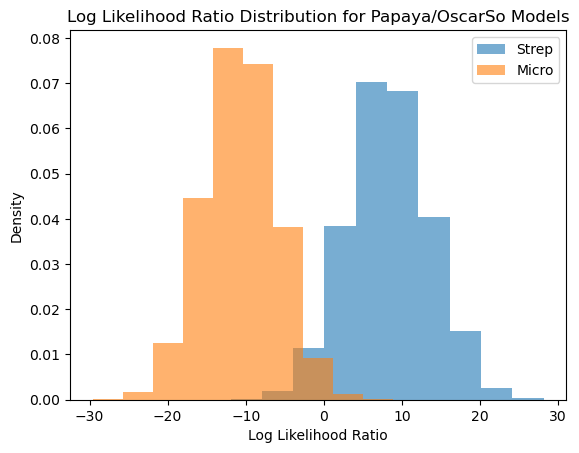

In [17]:
plt.hist(strep_logs, label = "Strep", alpha = 0.6, density = True)
plt.hist(micro_logs, label = "Micro", alpha = 0.6, density = True)
plt.legend()
plt.xlabel("Log Likelihood Ratio")
plt.title("Log Likelihood Ratio Distribution for Papaya/OscarSo Models")
plt.ylabel("Density")
plt.show()

Below, I implement the same procedure as previously described to create an ROC plot for my Markov-based LLR method of classifying strep and micro sequences. For each value of `cutoff`, the method identifies a read as strep if its LLR is greater than `cutoff` and identifies the read as micro otherwise. I then plot the ROC curves for Moriarty's method and the Markov-based LLR method on the same plot, along with the negative control line $y = x$. 

This plot clearly shows that, for distinguishing between strep and micro phage, the Markov LLR model performs much better than the Moriarty Score. The ROC plot for the Markov method is much more similar to the ideal curve, jumping quickly from (0,0) to a sensitivity of 1. In contrast, the ROC curve for Moriarty's plot increases slowly, almost logarithmically, showing how it requires a much higher false positive rate in order to achieve near 100% sensitivity. That is, in order to correctly identify 100% of strep sequences, the Moriarty method accepts that we will be mistakenly classifying a large number of micro sequences as strep. In contrast, the Markov method is able to correctly identify all strep sequences with a much lower rate of mistakenly classifying micro sequences. 

In [18]:
sensitivity_markov = [] #stores sensitivity values for different cutoffs
fpr_markov = [] #store false positive rates for different cutoffs

for cutoff in np.linspace(-30, 30, num = 200): #loops through different cutoff values
    strep_booleans = np.array(strep_logs) >= cutoff #true positive strep ID's marked as True, False otherwise
    strep_indicators = strep_booleans.astype(int) #true positive strep ID's marked as 1, 0 otherwise

    micro_booleans = np.array(micro_logs) >= cutoff #false positive strep ID's marked as True, False otherwise
    micro_indicators = micro_booleans.astype(int) #false positive strep ID's marked as 1, 0 otherwise
    
    true_pos = np.sum(strep_indicators) #number of true positive ID's
    false_pos = np.sum(micro_indicators) #number of false positive ID's

    true_neg = np.sum(micro_indicators == 0) #number of true negative ID's
    false_neg = np.sum(strep_indicators == 0) #number of false negative ID's

    sensitivity_markov.append(true_pos/(true_pos + false_neg)) #computes + appends sensitivity value
    fpr_markov.append(1 - (true_neg/(true_neg + false_pos))) #computes + appends false positive rate

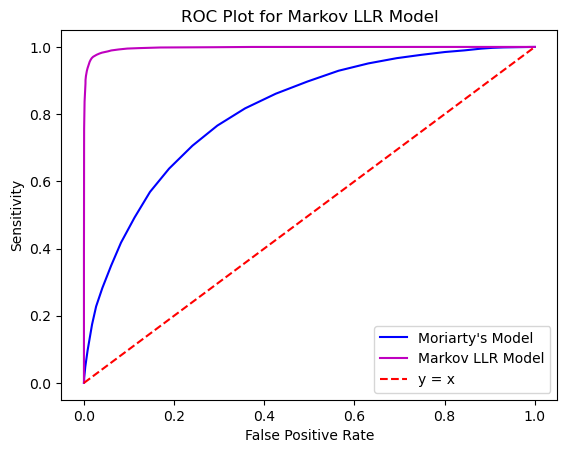

In [19]:
plt.plot(fpr, sensitivity, label = "Moriarty's Model", c = 'b')
plt.plot(fpr_markov, sensitivity_markov, label = "Markov LLR Model", c = 'm')
x = np.linspace(0, 1, num = 200)
plt.plot(x,x, label = "y = x", c = 'r', linestyle = '--')
plt.xlabel("False Positive Rate")
plt.ylabel("Sensitivity")
plt.legend()
plt.title("ROC Plot for Markov LLR Model")
plt.show()

## 3. how good is your method?

Below, I loop through the space of 4000 evenly spaced cutoff values from [-30, 30), ID'ing a read as strep if its LLR value is greater than the cutoff and otherwise identifying the read as micro. I choose a higher number of cutoff values than when making the ROC plot to get as close to a sensitivity value of 0.9 as possible. 

The code within the `for` loop that loops through the cutoff values is otherwise identical to the code used to produce the above ROC plot. The only difference is that at the end, I include an `if` statement that checks whether the sensitivity is equal to or less than the desired value of 0.9. Since we are starting our loop from the low extremes of cutoff values, our sensitivity will initially be 1 and decrease as we iterate through our loop. Therefore, the `if` condition identifies the first time we see a sensitivity less than or equal to 0.9. If this condition is met, I print the associated threshold value and false positive rate. 

From the output below, we see that a sensitivity of 0.9 for this Markov-based LLR test is achieved at around a threshold of 1.703 and an associated false positive rate of 0.0035. Interpreting this metric, we see that choosing a cutoff of $LLR = 1.7029$ means that, on average, 90% of strep sequences will correctly identified as strep. At this cutoff value, we also accept that 0.35% of micro sequences will mistakenly be identified as strep. This initially seems like a pretty precise test, which supports the validity of our method.

In [20]:
cutoffs = np.linspace(-30, 30, num = 4000)

for i in range(len(cutoffs)):
    strep_booleans = np.array(strep_logs) >= cutoffs[i]
    strep_indicators = strep_booleans.astype(int)

    micro_booleans = np.array(micro_logs) >= cutoffs[i]
    micro_indicators = micro_booleans.astype(int)
    
    true_pos = np.sum(strep_indicators)
    false_pos = np.sum(micro_indicators)

    true_neg = np.sum(micro_indicators == 0)
    false_neg = np.sum(strep_indicators == 0)

    sensitivity = true_pos/(true_pos + false_neg)
    fpr = (1 - (true_neg/(true_neg + false_pos)))

    
    if sensitivity <= 0.9:
        print(f"Sensitivity of {np.round(sensitivity, decimals = 4)} is achieved at a threshold of {np.round(cutoffs[i], decimals = 4)}, with a false positive rate of {np.round(fpr, decimals = 4)}.")
        break

Sensitivity of 0.8998 is achieved at a threshold of 1.7029, with a false positive rate of 0.0035.


We want to find the false discovery rate (FDR) in a metagenomic sample where 99.9% of reads are from micro and 0.1% are from strep. First, some notation. Let $Micro$ be the event that a read is from a micro phage, $Pos$ be the event of a positive test using our model at the 90% sensitivity cutoff, and $Strep$ be the event that a read is from a strep phage. In these calculations, we are assuming that we are equally likely to sample any of the reads present in the metagenomic sample. 

By Bayes' Rule: $FDR = P(Micro \mid Pos) =  \frac{P(Pos \mid Micro)P(Micro)}{P(Pos)} = \frac{P(Pos \mid Micro)P(Micro)}{P(Pos \mid Micro)P(Micro) + P(Pos \mid Strep)P(Strep)} = \frac{FDR(0.999)}{FDR(0.999) + TPR(0.001)} = \frac{0.0035(0.999)}{0.0035(0.999) + 0.9(0.001)} \approx 0.795$

Therfore, in the metagenomic sample to which we were hoping to apply this method, we expect that 79.5% of positive reads are false positives! At first, this may appear surprising given our previous sensitivity analysis, but it makes sense given that the metagenomic contains an overwhelming 99.9% micro reads! At that rate, we're so much more likely to encounter a micro read than a strep read that our false positive rate of 0.003 fails to suppress the false discovery rate. In this practical context, our Markov LLR test is less successful at distinguishing the two phage types than it may have first appeared. To potentially correct for this high false discovery rate, we'd need to select a more stringent cutoff (accepting lower sensitivity in order to get a lower false positive rate). 

If this tradeoff still fails to produce acceptable false discovery rates when applied to metagenomic samples, we'd probably need to rethink our model construction. Perhaps higher order Markov models could better distinguish between strep and micro reads than our 2nd order model. Some intuition is that nucleotide sequences are 3-mer sequences due to codon-based translation, so using a $k = 3$ order Markov model for our LLR calculations might provide us with more power. 